# Lab 5: Matrix Factorization and Linear Dimensionality Reduction
Covered Topics:
> PCA

> Data Whitening

> Robust PCA

> Data Manipulation

# Motivation
> Implement PCA and achieve data whitening based on it

> Try to explore the algorithm of robust PCA (RPCA) based on the guidance. Learn how to reformulate problems approximately, and do your second alternating optimization algorithm
(Do you remember which is your first alternating optimization algorithm in this course?)

> Learn how to change data statistics by machine learning-guided data manipulation

# Data Simulator and Testing function (Don't change them)

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def zero_mean_point_cloud_simulator(n_pts: int = 50, r_seed: int = 42) -> dict:
    """
    Simulate a set of zero-mean 2D points with Gaussian noise or outliers
    :param n_pts: the number of 2D points
    :param r_seed: the random seed
    :return:
        a dictionary containing the points with Gaussian noise and those with outliers, respectively
    """
    x = 4 * (np.random.RandomState(r_seed).rand(n_pts, 1) - 0.5)
    y = 0.4 * x
    data = np.concatenate((x, y), axis=1)
    pts1 = data + 0.1 * np.random.RandomState(r_seed).randn(n_pts, 2)
    pts2 = data + 0.01 * np.random.RandomState(r_seed).randn(n_pts, 2)
    idx = np.random.RandomState(r_seed).permutation(n_pts)
    n_noise = int(0.2 * n_pts)
    pts2[idx[:n_noise], :] = np.random.RandomState(r_seed).randn(n_noise, 2) + np.array(
        [0.5, 1.5]
    ).reshape((1, 2))
    return {"gauss": pts1, "outlier": pts2}


def visualization_pts(pts: np.ndarray, label: str, point_type: str):
    plt.plot(pts[:, 0], pts[:, 1], point_type, label=label)


def visualization_line(v: np.ndarray, label: str, line_type: str):
    xs = 5 * (np.arange(0, 100) / 100 - 0.5)
    ys = v[1] / v[0] * xs
    plt.plot(xs, ys, line_type, label=label)

# Task 1
Implement a PCA function, which takes the data matrix and the number of principal components you want as its input.

# Solution 1
In this problem, PCA is achieved by performing Eigenvalue Decomposition: 

**Step1**: Demeaning the data to be column-wise zero mean. From the lecture note we know that demeaned $\boldsymbol{X}'$ is derived by
$$
\boldsymbol{X}^\prime = \boldsymbol{X} - \boldsymbol{1}_N\boldsymbol{\overline{x}}^\top=(\boldsymbol{I}_N - \frac{1}{N}\boldsymbol{1}_{N\times N})\boldsymbol{X}
$$
where $\boldsymbol{1}_{N\times N}=\boldsymbol{1}_N\boldsymbol{1}_N^T$. However, this may lose some precision when $N$ is large. So we can use the `X' = X - np.mean(X, axis=0)  # (N, D)` to get the demeaned data.

**Step2**: Compute the eigenvalues and corresponding eigenvectors of $\boldsymbol{X}'^\top\boldsymbol{X}'$

**Step3**: Sort the eigenvalues and corresponding eigenvectors in descending order to get the principal components.

In [217]:
def pca(
    xs: np.ndarray, n_pc: int = 2
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Implement PCA via eigen-decomposition
    :param xs: a data matrix with (N, D), N is the number of samples, D is the dimension of sample space
    :param n_pc: the number of principal components we would like to output
    :return:
        the matrix containing top-k principal components, with size (D, n_pc)
        the vector indicating the top-k eigenvalues, with size (n_pc)
        the data recovered from the projections along the principal components, with size (N, D)
        the zero-mean data with size (N, D)
    """
    N = xs.shape[0]
    # Step1: Process the data `xs` to be columnwise zero-meaned X, size (N,D)
    X = xs - np.mean(xs, axis=0)  # (N, D)
    # Step2: Compute the eigenvalues and eigenvectors of X^TX, size (D,D)
    eigvals, eigvecs = np.linalg.eig(X.T @ X)
    # Step3: Sort the eigenvalues in descending order
    idx = np.argsort(-eigvals)  # Sort the eigenvalues in descending order
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    # Step4: Compute the top-k principal components, size (D, n_pc)
    V_pc = eigvecs[:, :n_pc]
    eigvals_pc = eigvals[:n_pc]
    # Step5: Recover `xs` from the projections along the principal components
    X_recover = X @ V_pc @ V_pc.T + np.mean(xs, axis=0)   # (N, D)(D, n_pc)(n_pc, D)->(N, D)
    return V_pc, eigvals_pc, X_recover, X

Here we look at a simple example to illustrate the PCA algorithm.

`V_pc` is the principal components, `eigvals` is the eigenvalues, `X_pc` is the projected data on the principal components.

In [218]:
xs = np.array([[1,2,3,4],[2,3,4,5],[3,4,5,6],[4,5,6,7],[5,6,7,8]])
V_pc, eigvals, X_recover, X = pca(xs, 2)
X_pc = xs @ V_pc
V_pc, eigvals, X_pc, X_recover

(array([[-5.00000000e-01,  8.71834232e-17],
        [-5.00000000e-01, -8.16496581e-01],
        [-5.00000000e-01,  4.08248290e-01],
        [-5.00000000e-01,  4.08248290e-01]]),
 array([4.00000000e+01, 5.79098833e-31]),
 array([[ -5.        ,   1.22474487],
        [ -7.        ,   1.22474487],
        [ -9.        ,   1.22474487],
        [-11.        ,   1.22474487],
        [-13.        ,   1.22474487]]),
 array([[1., 2., 3., 4.],
        [2., 3., 4., 5.],
        [3., 4., 5., 6.],
        [4., 5., 6., 7.],
        [5., 6., 7., 8.]]))

# Task 2
Achieve data whitening based on your PCA method.

# Solution 2
Whitening means making each feature zero-mean, unit-variance and uncorrelated to each other. Given $\boldsymbol{X}=[\boldsymbol{x_1},\cdots,\boldsymbol{x_D}]$ with $D$ features, we similarily process the data to be columnwise zero-meaned: 
$$
    \boldsymbol{X'}=\boldsymbol{X}-\boldsymbol{1}_N\boldsymbol{\bar x}^\top
$$
where $\boldsymbol{\overline{x}}=\dfrac{1}{N}\sum\limits_{i=1}^{N}\boldsymbol{x_i}$. Then the estimate covariance matrix measuring the covariance between feature $i$ and $j$ is given by
$$
    \boldsymbol{\hat \Sigma}=\dfrac{1}{N-1}(\boldsymbol{X}-\boldsymbol{{1}_N}\boldsymbol{\overline{x}}^\top)^\top(\boldsymbol{X}-\boldsymbol{{1}_N}\boldsymbol{\overline{x}}^\top)=\dfrac{1}{N-1}\boldsymbol{X'}^\top \boldsymbol{X'}
$$
Then we can **whiten the data** by
$$
    \boldsymbol{\tilde X}=(\boldsymbol{X}-\boldsymbol{{1}_N}\boldsymbol{\overline{x}}^\top)\boldsymbol{\hat \Sigma}^{-\frac{1}{2}}=\boldsymbol{X'}\boldsymbol{\hat \Sigma}^{-\frac{1}{2}}
$$
This is very similar to PCA. By EVD we know
$$
    \boldsymbol{X'}^\top \boldsymbol{X'}=\boldsymbol{V}\boldsymbol{\Lambda}\boldsymbol{V}^\top=(N-1)\boldsymbol{\hat \Sigma}
$$
Therefore
$$
    (N-1)\boldsymbol{\tilde X}=(N-1)\boldsymbol{X'}\boldsymbol{\hat \Sigma}^{-\frac{1}{2}}=\underbrace{\boldsymbol{X'}}_{\text{Shifting\ }}\underbrace{\boldsymbol{V}}_{\text{PCA Matrix\ }}\underbrace{\boldsymbol{\Lambda}^{-\frac{1}{2}}}_{\text{Scaling}}\boldsymbol{V}^\top
$$

In [209]:
def data_whitening(xs: np.ndarray) -> np.ndarray:
    """
    Implement data whitening via the method in Lecture 2 or PCA
    :param xs: the data matrix with size (N, D), N is the number of samples
    :return:
        ys: the data yield normal distribution, with size (N, D)
    """
    N, D = xs.shape
    V_pc, eigvals, X_recover, X = pca(xs, D)
    epsilon = 1e-6  # A small constant to avoid zero eigenvalues
    eigvals += epsilon
    # Data whitening
    ys = X @ V_pc @ np.diag(eigvals ** (-0.5)) @ V_pc.T # (N, D)(D, n_pc)(n_pc, n_pc)(n_pc, D)
    return ys

In [213]:
xs = np.array([[2,0,0,4],[0,5,1,1],[2,0,0,4],[0,9,0,4]])
ys = data_whitening(xs)
print(ys)
# Whitening means zero mean and identity covariance matrix
# Verify the correctness of the data whitening
np.mean(ys, axis=0), np.var(ys, axis=0)

[[ 0.15246035 -0.431609   -0.06361565  0.19084694]
 [-0.25446259  0.10673133  0.25958758 -0.77876274]
 [ 0.15246035 -0.431609   -0.06361565  0.19084694]
 [-0.05045812  0.75648666 -0.13235629  0.39706886]]


(array([ 1.20198990e-14,  2.66453526e-15,  6.22418783e-15, -1.48492330e-15]),
 array([0.02844639, 0.23905908, 0.02324945, 0.20924505]))

# Task 3
Implement a robust PCA (RPCA) algorithm via alternating optimization. Given a data
matrix $X \in \mathbb{R}^{N \times D}$, the original RPCA problem is
$$
\min_{\boldsymbol{X}}\|\boldsymbol{X}_{noise}-\boldsymbol{X}\|_1,\  s.t.\ \text{rank}(\boldsymbol{X})\le L \tag*{(1)}
$$
Assuming the target $\boldsymbol{X} = \boldsymbol{L} + \boldsymbol{S}$, where $\boldsymbol{L}$ is low-rank and $\boldsymbol{S}$ is sparse, we can solve (1) by optimizing the following two subproblems iteratively. At the $k$-th iteration:
\begin{align*}
    \text{P1}:& \boldsymbol{L}^{(k)}=\arg\min_{\boldsymbol{L}}\|\boldsymbol{X}_{noise}-\boldsymbol{L}-\boldsymbol{S}^{(k-1)}\|_F^2,\ s.t.\ \text{rank}(\boldsymbol{L})\le L\\
    \text{P2}:& \boldsymbol{S}^{(k)}=\arg\min_{\boldsymbol{S}}\|\boldsymbol{X}_{noise}-\boldsymbol{L}^{(k)}-\boldsymbol{S}\|_F^2,\ s.t.\ \|\boldsymbol{S}\|_0\le \tau ND
\end{align*}
where $\|S\|_0$ counts the number of nonzero elements in $S$, and $\tau \in (0, 1)$ controls the ratio of nonzero elements.

[Note]: The method may not be the state-of-the-art, but it's doable






# Solution 3
At the $k$-th iteration:

In the first step, we fix $\boldsymbol{S}^{(k-1)}$ and solve for $\boldsymbol{L}^{(k)}$. From the restriction $\text{rank}(\boldsymbol{L})\le L$, $(\boldsymbol{L}^{(k)})^*$ is can be optimized by taking the top-L principal components of $(\boldsymbol{X}-\boldsymbol{S}^{(k-1)})$.

In the second step, we fix $\boldsymbol{L}^{(k)}$ and solve for $\boldsymbol{S}^{(k)}$. From the restriction $\|\boldsymbol{S}\|_0\le \tau ND$, we can use the hard-thresholding operator defined before to achieve the scarcity of $\boldsymbol{S}$.

Recall that PCA is essentially **the least-square data denoising under i.i.d. Gaussian noise**, the $\boldsymbol{L}$ obtained from iterations is the denoised data $\boldsymbol{X}$. So we only need to perform PCA on the denoised data $\boldsymbol{X}$ to get the principal components.







In [219]:
def hard_thresholding(x: np.ndarray, ratio: float) -> np.ndarray:
    """
    The hard-thresholding operator
    :param x: input array with arbitrary size
    :param ratio: the ratio of nonzero elements
    :return:
        y = x,  if |x| > a threshold
            0,  otherwise
    """
    # TODO: change the code below,
    # Implement a hard-thresholding method (given a ratio of nonzero elements, determine the threshold adaptively)
    # We want to keep the top `rario` * 100% of non-zero elements
    x_sorted = np.sort(np.abs(x).flatten()) # Flatten the input array and sort by the absolute value
    idx = int((1 - ratio) * len(x_sorted))  # Determine the index of the threshold
    threshold = x_sorted[idx]               # Get the threshold
    y = np.where(np.abs(x) > threshold, x, 0)   # Apply the hard-thresholding operator to x
    return y

def robust_pca_hard(
    xs: np.ndarray, n_pc: int = 2, n_alt: int = 100, ratio_nz: float = 0.1
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Implement your own algorithm to solve the robust PCA problem via
    optimizing the low-rank factorization of data matrix (X in R^{N x D}) explicitly, i.e.,

    min_{L, S} ||X - (L + S)||_F^2
    s.t. rank(L) <= n_pc, ||S||_0 < ratio_nz * (N * D)

    Hint: you may want to solve L and S in an alternating optimization manner:
    1) Fix L and solve
        L = argmin_L ||X - (L + S)||_F^2
        s.t. rank(L) <= n_pc
    2) Fix S and solve
        S = argmin_S ||X - (L + S)||_F^2,
        s.t.. ||S||_0 < ratio_nz * (N * D)

    :param xs: a data matrix with (N, D), N is the number of samples, D is the dimension of sample space.
    :param n_pc: the number of principal components we would like to output.
    :param n_alt: the number of steps for alternating optimization.
    :param ratio_nz: the ratio of non-zero elements in the whole matrix.
    :return:
        the matrix containing top-k principal components, with size (D, n_pc)
        the vector indicating the top-k eigenvalues, with size (n_pc)
        the data recovered from the projections along the principal components, with size (N, D)
        the zero-mean data with size (N, D)
    """
    # TODO: Change the code below, implement the Robust PCA according to the comments
    N, D = xs.shape
    L = np.zeros_like(xs)   # Initialize low-ranked L as zeros
    S = np.zeros_like(xs)   # Initialize sparse S as zeros
    xs0 = xs - np.mean(xs, axis=0)  # Zero-mean the data

    for _ in range(n_alt):
        # Fix S and solve L
        _, _, L, _ = pca(xs0 - S, n_pc)
        # Fix L and solve S
        S = hard_thresholding(xs0 - L, ratio_nz)
    
    # L is the denoised `xs0`. We perform PCA on it to get the principal components
    eigvals, eigvecs = np.linalg.eig(L.T @ L)
    idx = np.argsort(-eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    # Top-`n_pc` principal components, size (D, n_pc)
    V_pc = eigvecs[:, :n_pc]   
    # Top-`n_pc` eigenvalues
    eigvals_pc = eigvals[:n_pc]
    # Recover the data from the projections along the principal components
    X_recover = L @ V_pc @ V_pc.T + np.mean(xs, axis=0) # (N, D)(D, n_pc)(n_pc, D)->(N, D)
    
    return V_pc, eigvals_pc, X_recover, xs

# Task 4
**Data manipulation:** Given a set of zero-mean data, i.e., $X \in \mathbb{R}^{N \times D}$, whose covariance matrix is $\boldsymbol{\Gamma_X} \in \mathbb{R}^{D \times D}$, we have a chance to add two outliers (Suppose that you are a data attacker. Because of limited budgets, you can only add two outliers), i.e., $\boldsymbol{x}_1$ and $\boldsymbol{x}_2$ into $\boldsymbol{X}$ and formulate a new data matrix $\boldsymbol{\hat X}\in \mathbb{R}^{(N+2)\times D}$. The two outliers satisfy that $\|\boldsymbol{x}_1\|_2=\|\boldsymbol{x}_2\|_2=1$.

Try to ensure $\boldsymbol{\hat X}$ to be a zero-mean data matrix and maximize the difference between its covariance matrix $\boldsymbol{\Gamma_{\hat X}}$ and the original $\boldsymbol{\Gamma_{X}}$ , i.e., $\max_{\boldsymbol{\hat X}}\|\boldsymbol{\Gamma_{\hat X}}-\boldsymbol{\Gamma_{X}}\|_F^2$. (Try to design a "data poisoning" strategy to change the covariance of the data as much as possible.)


# Solution 4
Given the original data matrix $\boldsymbol{X}$, its covariance matrix is given by $\boldsymbol{\Gamma_X}=\dfrac{1}{N-1}\boldsymbol{X^\top X}$. When two outliners $\boldsymbol{x}_1,\boldsymbol{x}_2$ are added to $\boldsymbol{X}$, the new data matrix is $\boldsymbol{\hat X}=\begin{bmatrix}\boldsymbol{X}\\\boldsymbol{x}_1\\\boldsymbol{x}_2\end{bmatrix}$ (implemented by `np.vstack` that stacks arrays in sequence vertically) and the newcovariance matrix of $\boldsymbol{\hat X}$ is now 
$$
\boldsymbol{\Gamma_{\hat X}}=\dfrac{1}{N+1}\boldsymbol{\hat X^\top \hat X}= \dfrac{1}{N+1}\left(\boldsymbol{X^\top X}+\boldsymbol{x_1 x_1^\top}+\boldsymbol{x_2 x_2^\top}\right)
$$
Since the old data matrix and the new data matrix are both zero-mean, we must ensure that $\boldsymbol{x_1}+\boldsymbol{x_2}=0$, so
\begin{align*}
\boldsymbol{\Gamma_{\hat X}}&=\dfrac{1}{N+1}\left(\boldsymbol{X^\top X}+\boldsymbol{x_1 x_1^\top}+\boldsymbol{(-x_1)(-x_1)^\top}\right)=\dfrac{1}{N+1}\left(\boldsymbol{X^\top X}+2\boldsymbol{x_1 x_1^\top}\right)\\
&=\dfrac{1}{N+1}\left((N-1)\boldsymbol{\Gamma_X}+2\boldsymbol{x_1 x_1^\top}\right)
\end{align*}
Therefore, to maximize the difference between $\boldsymbol{\Gamma_{\hat X}}$ and $\boldsymbol{\Gamma_X}$, $\boldsymbol{x_1}$ should be deliberately chosen as the eigenvector corresponding to the largest eigenvalue of $\boldsymbol{\Gamma_X}$, i.e., **the first principal component of the original data matrix** $\boldsymbol{X}$, and then choose $\boldsymbol{x_2}=-\boldsymbol{v_1}$. Normalization is implemented to ensure that $\|\boldsymbol{x}_1\|_2=\|\boldsymbol{x}_2\|_2=1$.

In [220]:
def coupled_outlier_poisoning(xs: np.ndarray):
    """
    Generate two outliers "x1" and "x2", with constraints ||x1||_2 = ||x2||_2 = 1 and x1 + x2 = 0
    :param xs: a data matrix with size (N, D), N is the number of samples
    :return:
        the outliers with size (2, D)
        the new data matrix with the outlier, with size (N+2, D)
    """
    # TODO: change the code below and implement the data poisoning method
    V_pc, _, _, _ = pca(xs)
    # choose x1 as the first pc normalized
    x1 = V_pc[:, 0]  # (D, )
    x1 /= np.linalg.norm(x1)
    # vstack: Stack arrays in sequence vertically (row wise)
    outliers = np.vstack((x1, -x1))
    X_new = np.vstack((xs, outliers))

    return outliers, X_new

# Test Script

(50, 2) (52, 2)


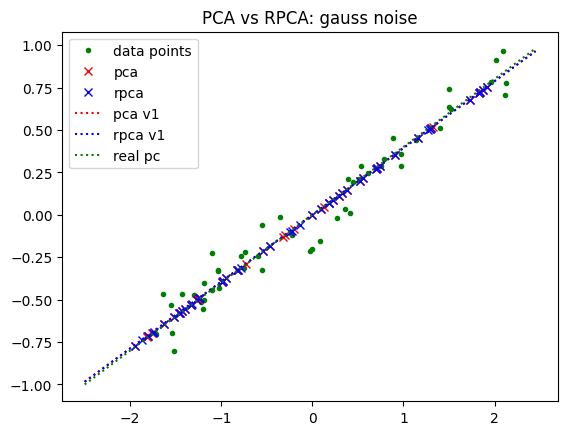

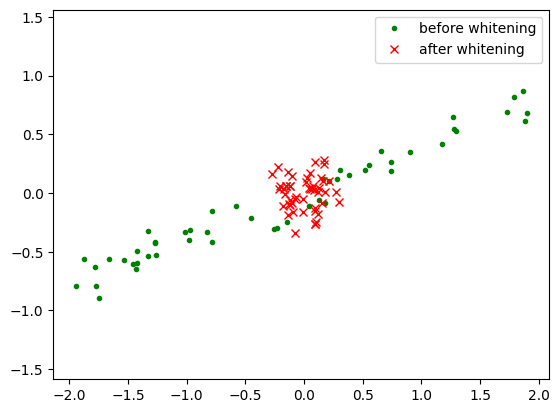

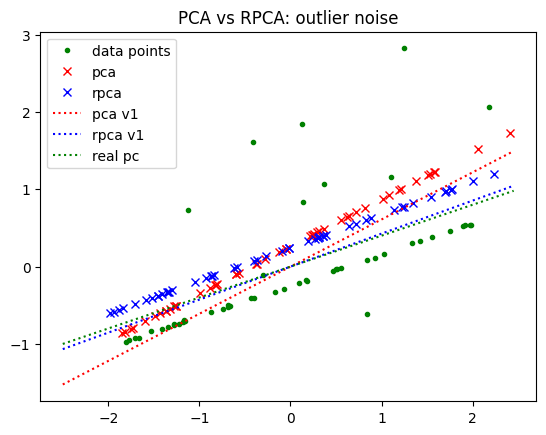

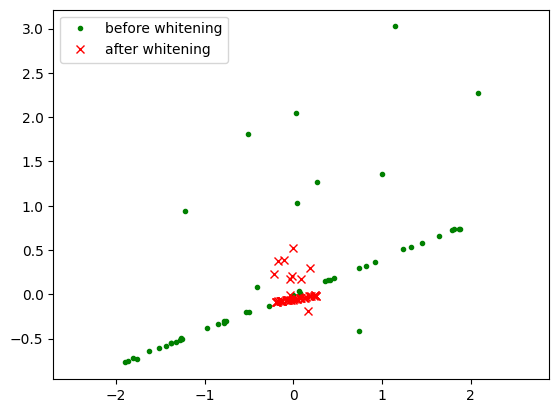

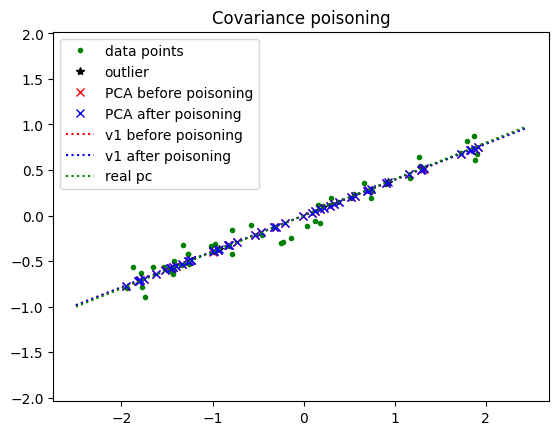

In [223]:
# Testing script
if __name__ == "__main__":
    data = zero_mean_point_cloud_simulator()
    for noise_type in data.keys():
        vs1, lambdas1, xhat1, xs1 = pca(data[noise_type], n_pc=1)
        vs2, lambdas2, xhat2, _ = robust_pca_hard(
            data[noise_type], n_pc=1, ratio_nz=0.1
        )
        xhat3 = data_whitening(data[noise_type])

        plt.figure()
        visualization_pts(xs1, label="data points", point_type="g.")
        visualization_pts(xhat1, label="pca", point_type="rx")
        visualization_pts(xhat2, label="rpca", point_type="bx")
        visualization_line(v=vs1, label="pca v1", line_type="r:")
        visualization_line(v=vs2, label="rpca v1", line_type="b:")
        visualization_line(v=np.array([1, 0.4]), label="real pc", line_type="g:")
        result = "PCA vs RPCA: {} noise".format(noise_type)
        plt.title(result)
        plt.legend()
        # plt.savefig("result_{}.png".format(noise_type))
        # plt.close("all")

        plt.figure()
        visualization_pts(data[noise_type], label="before whitening", point_type="g.")
        visualization_pts(xhat3, label="after whitening", point_type="rx")
        plt.legend()
        plt.axis("equal")
        # plt.savefig("whitening_{}.png".format(noise_type))
        # plt.close("all")

    vs1, lambdas1, xhat1, xs1 = pca(data["gauss"], n_pc=1)
    outliers, data_noisy = coupled_outlier_poisoning(data["gauss"])
    print(data["gauss"].shape, data_noisy.shape)

    vs2, lambdas2, xhat2, _ = pca(data_noisy, n_pc=1)
    plt.figure()
    visualization_pts(data["gauss"], label="data points", point_type="g.")
    visualization_pts(outliers, label="outlier", point_type="k*")
    visualization_pts(xhat1, label="PCA before poisoning", point_type="rx")
    visualization_pts(xhat2, label="PCA after poisoning", point_type="bx")
    visualization_line(v=vs1, label="v1 before poisoning", line_type="r:")
    visualization_line(v=vs2, label="v1 after poisoning", line_type="b:")
    visualization_line(v=np.array([1, 0.4]), label="real pc", line_type="g:")
    result = "Covariance poisoning"
    plt.title(result)
    plt.legend()
    plt.axis("equal")
    # plt.savefig("poisoning_pca.png")
    # plt.close("all")